In [1]:
pip install --upgrade scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import sys
import matplotlib.pyplot as plt
import torch
from sklearn import datasets
from sklearn.linear_model import LogisticRegression
from sklearn.manifold import TSNE
import numpy as np
from sklearn.preprocessing import StandardScaler
from torch.optim import Adam
from torch.utils.data import DataLoader
from sklearn.metrics import (ConfusionMatrixDisplay, classification_report, confusion_matrix)
sys.path.append("../")
from loss import NTXent
from model import SCARF
from sklearn.utils import resample
from dataset import ExampleDataset
from utils import dataset_embeddings, fix_seed, train_epoch
seed = 1234
fix_seed(seed)

# Data

In [5]:
df = pd.read_csv('FM.csv')
#df.head()
#print('column name', df.columns)
for col in df.columns:
    if df[col].dtype == 'object':
        df[col] = pd.to_numeric(df[col], errors='coerce')
        df[col] = df[col].astype(float) 
df['Age'] = df['YY1A1'] - df['birthdate_y']

/var/folders/2w/18__62n56y74_dvz41zy8bg40000gn/T/ipykernel_42537/2306050883.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['Age'] = df['YY1A1'] - df['birthdate_y']


In [7]:
FBG_Index = df.columns.get_loc('FBG') #355
AST_main_Index = df.columns.get_loc('AST_main')  #383
data = df.iloc[:, FBG_Index:AST_main_Index+1]
data[['Age','Sex', 'FH_DUTCH_Score_final','FH_DUTCH_Score_final_Code']] = df[['Age','Sex', 'FH_DUTCH_Score_final','FH_DUTCH_Score_final_Code']]

In [8]:
null_percentages = data.isnull().sum() / len(data) * 100
print('null_percentages', null_percentages)
cols_to_drop = null_percentages[null_percentages > 10].index.tolist()
data.drop(cols_to_drop, axis=1, inplace=True)

null_percentages FBG                           0.207361
HbA1c                         9.383100
TotalCholesterol              0.414723
Triglycerides                 0.000000
HDL_Cholesterol               0.000000
LDL_Cholesterol               0.051840
RBC                           6.428201
Hb                            6.220840
HCT                           6.376361
WBC                           6.428201
MCV                           6.376361
MCH                           6.480041
Neutrophil                   10.108865
MCHC                         58.890617
Lymphocyte                    8.035251
RDW_CV                        7.931571
MXD                          23.276309
RDW_SD                       74.805599
Neutrophils                  69.051322
Platelet                      8.346293
Lymphocytes                  70.710213
P_LCR                        75.427683
MPV                          67.081389
PDW                          12.078797
MCD                          82.011405
MXD1    

In [9]:
print(data['FH_DUTCH_Score_final_Code'].value_counts())

FH_DUTCH_Score_final_Code
2.0    950
1.0    700
3.0    148
4.0     72
Name: count, dtype: int64


In [10]:
def my_fillna(df):
    conditions = [
        df['FH_DUTCH_Score_final'] > 8,
        (df['FH_DUTCH_Score_final'] > 5) & (df['FH_DUTCH_Score_final'] <= 8),
        (df['FH_DUTCH_Score_final'] >= 3) & (df['FH_DUTCH_Score_final'] <= 5),
        df['FH_DUTCH_Score_final'] < 3
    ]
    choices = [4, 3, 2, 1]
    df['FH_DUTCH_Score_final_Code'] = df['FH_DUTCH_Score_final_Code'].fillna(pd.Series(np.select(conditions, choices)))
    return df

In [11]:
#data['FH_DUTCH_Score_final_Code'].fillna()
data = my_fillna(data)
data['FH_DUTCH_Score_final_Code'].isnull().sum()

0

FH_DUTCH_Score_final_Code
2.0    966
1.0    743
3.0    148
4.0     72
Name: count, dtype: int64


<Axes: ylabel='Type'>

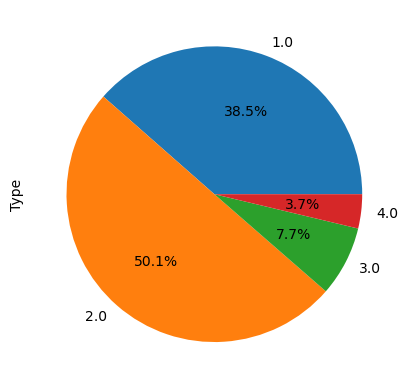

In [12]:
print(data["FH_DUTCH_Score_final_Code"].value_counts())
data.groupby('FH_DUTCH_Score_final_Code').size().plot(kind='pie',
                                       y = "FH_DUTCH_Score_final_Code",
                                       label = "Type",
                                       autopct='%1.1f%%')

In [13]:
data.drop("FH_DUTCH_Score_final_Code", axis = 1, inplace = True)

In [14]:
data.fillna(df.median(), inplace = True)
#data.dropna(axis = 0, inplace = True)
data.shape
print(data.isnull().sum() / len(data) * 100)

FBG                     0.0
HbA1c                   0.0
TotalCholesterol        0.0
Triglycerides           0.0
HDL_Cholesterol         0.0
LDL_Cholesterol         0.0
RBC                     0.0
Hb                      0.0
HCT                     0.0
WBC                     0.0
MCV                     0.0
MCH                     0.0
Lymphocyte              0.0
RDW_CV                  0.0
Platelet                0.0
Age                     0.0
Sex                     0.0
FH_DUTCH_Score_final    0.0
dtype: float64


In [15]:
data["FH_DUTCH_Score_final"] = [0 if i<=5 else 1 for i in data["FH_DUTCH_Score_final"]]

In [16]:
target = data["FH_DUTCH_Score_final"]
data.drop("FH_DUTCH_Score_final", axis = 1, inplace = True)

train_data, test_data, train_target, test_target = train_test_split(
    data, 
    target, 
    test_size=0.2, 
    stratify=target, 
    random_state=seed,
)

In [17]:
Patients = pd.concat([train_data[train_target== 1],train_target[train_target== 1]], axis =1)
Healthy  = pd.concat([train_data[train_target== 0],train_target[train_target== 0]], axis =1)
print(Patients.shape)
print(Healthy.shape)

(176, 18)
(1367, 18)


In [18]:
Patients_upsample = resample(Patients,
             replace=True,
             n_samples=len(Healthy),
             random_state=42)

print(Patients_upsample.shape)
train_data = pd.concat([Patients_upsample, Healthy])
train_target = train_data["FH_DUTCH_Score_final"]
train_data.drop("FH_DUTCH_Score_final", axis = 1, inplace = True)

(1367, 18)


In [19]:
Patients_test = pd.concat([test_data[test_target== 1],test_target[test_target== 1]], axis =1)
Healthy_test  = pd.concat([test_data[test_target== 0],test_target[test_target== 0]], axis =1)
print(Patients_test.shape)
print(Healthy_test.shape)


(44, 18)
(342, 18)


In [20]:
Patients_upsample_test = resample(Patients_test,
             replace=True,
             n_samples=len(Healthy_test),
             random_state=42)

print(Patients_upsample_test.shape)


(342, 18)


In [21]:
test_data = pd.concat([Patients_upsample_test, Healthy_test])
test_target = test_data["FH_DUTCH_Score_final"]
test_data.drop("FH_DUTCH_Score_final", axis = 1, inplace = True)

In [22]:
scaler = StandardScaler()
train_data = pd.DataFrame(scaler.fit_transform(train_data), columns=train_data.columns)
test_data = pd.DataFrame(scaler.transform(test_data), columns=test_data.columns)

In [23]:
# to torch dataset
train_ds = ExampleDataset(
    train_data.to_numpy(), 
    train_target.to_numpy(), 
    columns=train_data.columns
)
test_ds = ExampleDataset(
    test_data.to_numpy(), 
    test_data.to_numpy(), 
    columns=test_data.columns
)

print(f"Train set: {train_ds.shape}")
print(f"Test set: {test_ds.shape}")
#train_ds.to_dataframe().head()

Train set: (2734, 17)
Test set: (684, 17)


# Training

In [ ]:
batch_size = 128
epochs = 100
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)

model = SCARF(
    input_dim=train_ds.shape[1], 
    emb_dim=8,
    corruption_rate=0.6,
).to(device)
optimizer = Adam(model.parameters(), lr=0.01)
ntxent_loss = NTXent()

loss_history = []

for epoch in range(1, epochs + 1):
    epoch_loss = train_epoch(model, ntxent_loss, train_loader, optimizer, device, epoch)
    loss_history.append(epoch_loss)


Epoch 1:   0%|          | 0/22 [00:00<?, ?it/s]

In [ ]:
fig, ax = plt.subplots(figsize=(16, 8))
ax.plot(loss_history)
ax.set_xlabel("epoch")
ax.set_ylabel("loss")

# Evaluate embeddings

In [ ]:
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False)

# get embeddings for training and test set
train_embeddings = dataset_embeddings(model, train_loader, device)
test_embeddings = dataset_embeddings(model, test_loader, device)

print(train_embeddings.shape)
print(test_embeddings.shape)

In [ ]:
clf = LogisticRegression()

# vanilla dataset: train the classifier on the original data
clf.fit(train_data, train_target)
vanilla_predictions = clf.predict(test_data)

print(classification_report(test_target, vanilla_predictions))
cm = confusion_matrix(test_target, vanilla_predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

fig, ax = plt.subplots(figsize=(8, 8))
disp.plot(ax=ax)

In [ ]:
# embeddings dataset: train the classifier on the embeddings
clf.fit(train_embeddings, train_target)
vanilla_predictions = clf.predict(test_embeddings)

print(classification_report(test_target, vanilla_predictions))
cm = confusion_matrix(test_target, vanilla_predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

fig, ax = plt.subplots(figsize=(8, 8))
disp.plot(ax=ax)

# Visualzie using t-sne 

In [ ]:
tsne = TSNE(n_components=2, learning_rate="auto", init="pca", perplexity=15)
reduced = tsne.fit_transform(train_embeddings)
positive = train_target == 1

fig, ax = plt.subplots(figsize=(8, 8))

ax.scatter(reduced[positive, 0], reduced[positive, 1], label="positive")
ax.scatter(reduced[~positive, 0], reduced[~positive, 1], label="negative")
plt.legend()